**Important: This notebook will only work with fastai-0.7.x. Do not try to run any fastai-1.x code from this path in the repository because it will load fastai-0.7.x**

# Notes

## OOB Score

**Methodology**<br> The way **OOB** is calculated: take row 1, if it's appearing in tree 3,5,6, and 9 then the **OOB** score for row 1 is the average of the prediction of all the individual tree's prediction for the row 1. This happens for all the rows.

**Shortcoming**<br> Given that the **OOB** is always calculated in this manner, the **OOB score** on an average will be less than a **validation score**, because every *row* is going to be a subset of the trees to make its prediction, and with less number of trees we will get less accurate prediction. <br> Consider this: With the **validation** set we can use the whole forest to make predictions but with the **OOB** we cannot use the whole forest to make the predictions as **OOB** will always be using some of the trees to make it's predicition and not the entire forest. This happens because of the way **OOB** is constructed.

## Validation and Test Set importance

The goal of the **validation & test** set is to be able to create the datasets in such a way that they represent the most recent period. So, we first order the entire dataset in temporal order(CY) and then create the **validation & test** set in the following manner. 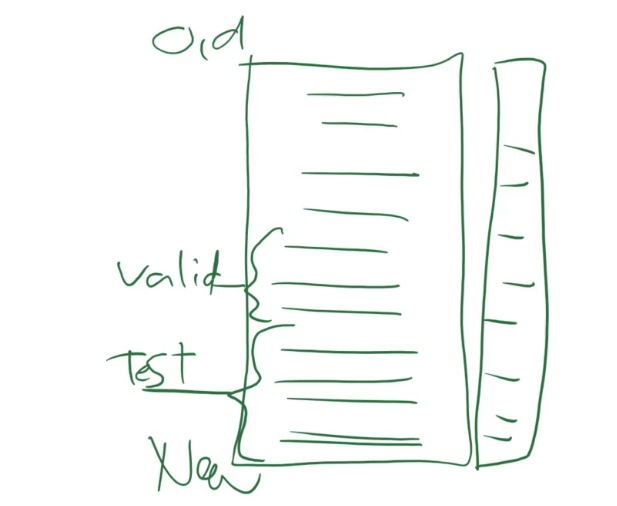

**Possible Validation Sets**<br>
- Random sample (4 years)
- Last month of data (July 15–August 15)
- Last 2 weeks (August 1–15)
- Same day range one month earlier (July 15–30)

**Final Result**<br> We would want the **validation set scores** and **test set scores** to be a single line. 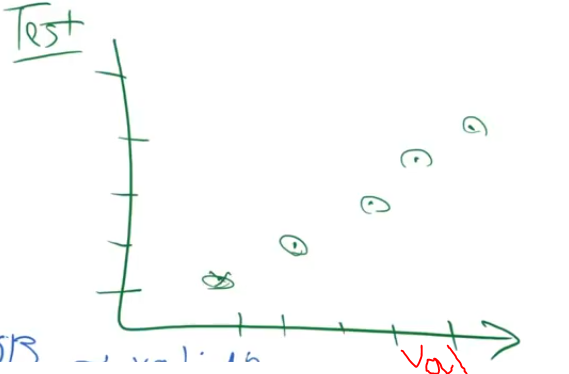 <br> **Methodology**:
1. Create 5 different models on the training dataset
    a. Just predict the average
    b. Group mean of the dataset
    c. Group mean of the last month of the data
    d. RF for the whole dataset 
    e. RF for the last 3 weeks
2. Combine the training and validation dataset and score each of the model
3. Score each of the model on the test set
4. Plot the scores of the train+validation set vs. the test set. 

##  Cross Validation

**Shortcoming**<br> 
1. Time; we will be building separate models each time and this takes a lot of time for a lot of data
2. For a temporal data there is no good way to **cross validate** as we would want our **validation set** to be as recent to the **test set** as possible. We cannot randomly take other parts of the dataset and build and model. 

##  Extrapolation

The *difficulty* of *RF* is that it **can't extrapolate** because all that an *RF* returns is an **average of the dependent variable** over the entire dataset. It has only seen old data and cannot predict next month as it hasn't seen it. Whereas, a **linear model** can find a relationship between time and the dependent variable and even though it has seen the same amount of data as the RF model it can still extrapolate. <br>**Methodology**<br>Avoid using time variables as predictors if there’s something else we could use that’s going to give us a better or stronger relationship that’s actually going to work in the future. <br> 
1. Step one create a dependent variable called is_valid 
2. 1 = present 0= absent
3. Build a random forest classifier with this dependent column
4. 2 possible results
    a. If you can predict the dependent, which means that there exists some time variables acting as predictors who are helping you to predict the validation set,  then it's not a random validation set and you will have to figure out how to create a validation set 
    b. If you can't predict then it's a random validation set
5. In our case we can predict the dependent and therefore it's not a random sample. Therefore, we do have some time variables as predictors 
6. Identify each of the temporal predictors
    i. Looking at the feature_importance we see that there are certain features which are extremely important for the predictions such as `'SalesID', 'saleElapsed', 'MachineID'`
    ii. Re run the RF model without these variables and check the feature_importance. Few more variables crop up to be important predictors, `'age', 'YearMade', 'saleDayofyear'`
    iii. Take all the features identified from the preceeding steps and drop them one by one from the RF model and check the validation score. 
            a. If the validation score  increases after dropping a variable then we know that there exists some relationship which is substituting this time variable dependency. In this way you can find out all the relationships, which are generalizable across time instead of having temporal dependency variables. 
            b. If the validation score decreases after dropping a variable that means a particular variable isn't helping predict the validation set translating to it's not a time dependent variable.
7. Drop all the variables, which are time dependent and check the validation score of the average price model. It should be better than the previous validation score, if not then you have still some temporal variables present in the model and the model isn't generalizable across time 


# Random Forest Model interpretation

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline

from fastai.imports import *
from fastai.structured import *
from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from IPython.display import display
from sklearn import metrics

In [3]:
set_plot_sizes(12,14,16)

## Load in our data from last lesson

%time returns the wall time; <br>
%prun returns the profiler, which step of the processing takes how much time; for instance: RF takes a lot of time to convert the data into array before processing it, therefore if we convert the training data to x= np.array(train, dtype=np.float32) and pass it later on to the RF

In [29]:
PATH = "E:/Fastai/Data/Bluebook/"

df_raw = pd.read_feather(f'{PATH}/Converted Data/bulldozers-raw')
df_trn, y_trn, nas = proc_df(df_raw, 'SalePrice')

In [30]:
def split_vals(a,n): return a[:n], a[n:]
n_valid = 12000
n_trn = len(df_trn)-n_valid
X_train, X_valid = split_vals(df_trn, n_trn)
y_train, y_valid = split_vals(y_trn, n_trn)
raw_train, raw_valid = split_vals(df_raw, n_trn)

#### Importance of building a good validation set

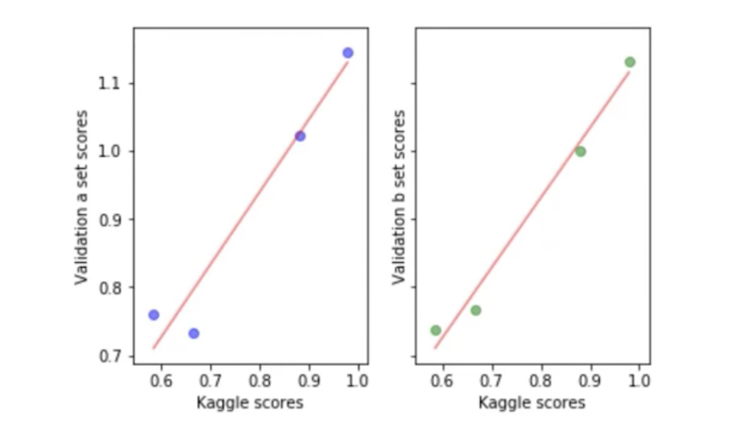

X-axis is the score Kaggle told us on the leaderboard, and y-axis he plotted the score on a particular validation set he was trying out to see whether the validation set was going to be any good. If your validation set is good, then the relationship between the leaderboards score (i.e. the test set score) should lie in a straight line. Ideally, it will lie on the $y = x$ line, but honestly that does not matter too much as long as relatively speaking it tells you which models are better than which other models, then you know which model is the best.

#### Constructing a validation set as close to the test set

* Close by date (i.e. most recent)
* First look at the date range of the test set (16 days), then look at the date range of the kernel which described how to get 0.58 on the leaderboard by taking an average (14 days).
* Test set begins on the day after pay day and ends on a pay day.
* Plot lots of pictures. Even if you did not know it was pay day, you want to draw the time series chart and hopefully see that every two weeks there is a spike and make sure that you have the same number of spikes in the validation set as the test set.

In [31]:
def rmse(x,y): return math.sqrt(((x-y)**2).mean())

def print_score(m):
    res = [rmse(m.predict(X_train), y_train), rmse(m.predict(X_valid), y_valid),
                m.score(X_train, y_train), m.score(X_valid, y_valid)]
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print(res)

In [32]:
df_raw

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,...,saleDay,saleDayofweek,saleDayofyear,saleIs_month_end,saleIs_month_start,saleIs_quarter_end,saleIs_quarter_start,saleIs_year_end,saleIs_year_start,saleElapsed
0,1139246,11.097410,999089,3157,121,3.0,2004,68.0,2,521D,...,16,3,320,False,False,False,False,False,False,1163635200
1,1139248,10.950807,117657,77,121,3.0,1996,4640.0,2,950FII,...,26,4,86,False,False,False,False,False,False,1080259200
2,1139249,9.210340,434808,7009,121,3.0,2001,2838.0,0,226,...,26,3,57,False,False,False,False,False,False,1077753600
3,1139251,10.558414,1026470,332,121,3.0,2001,3486.0,0,PC120-6E,...,19,3,139,False,False,False,False,False,False,1305763200
4,1139253,9.305651,1057373,17311,121,3.0,2007,722.0,1,S175,...,23,3,204,False,False,False,False,False,False,1248307200
5,1139255,10.184900,1001274,4605,121,3.0,2004,508.0,2,310G,...,18,3,353,False,False,False,False,False,False,1229558400
6,1139256,9.952278,772701,1937,121,3.0,1993,11540.0,0,790ELC,...,26,3,239,False,False,False,False,False,False,1093478400
7,1139261,10.203592,902002,3539,121,3.0,2001,4883.0,0,416D,...,17,3,321,False,False,False,False,False,False,1132185600
8,1139272,9.975808,1036251,36003,121,3.0,2008,302.0,2,430HAG,...,27,3,239,False,False,False,False,False,False,1251331200
9,1139275,11.082143,1016474,3883,121,3.0,1000,20700.0,1,988B,...,9,3,221,False,False,False,False,False,False,1186617600


# Confidence based on tree variance

For model interpretation, there's no need to use the full dataset on each tree - using a subset will be both faster, and also provide better interpretability (since an overfit model will not provide much variance across trees).

In [33]:
set_rf_samples(50000)

In [34]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
%time m.fit(X_train, y_train)
print_score(m)

Wall time: 30.6 s
[0.20602340010579148, 0.24761036636029535, 0.9112909503493176, 0.8905071854861039, 0.8942252061276055]


We saw how the model averages predictions across the trees to get an estimate - but how can we know the confidence of the estimate? One simple way is to use the standard deviation of predictions, instead of just the mean. This tells us the *relative* confidence of predictions - that is, for rows where the trees give very different results, you would want to be more cautious of using those results, compared to cases where they are more consistent. Using the same example as in the last lesson when we looked at bagging:

In [35]:
%time preds = np.stack([t.predict(X_valid) for t in m.estimators_])
np.mean(preds[:,0]), np.std(preds[:,0])

Wall time: 3.3 s


(9.34267167666297, 0.3450534942542098)

When we use python to loop through trees like this, we're calculating each in series, which is slow! We can use parallel processing to speed things up:

In [36]:
def get_preds(t): return t.predict(X_valid)
%time preds = np.stack(parallel_trees(m, get_preds))
np.mean(preds[:,0]), np.std(preds[:,0])

BrokenProcessPool: A process in the process pool was terminated abruptly while the future was running or pending.

(9.34267167666297, 0.3450534942542098)

We can see that different trees are giving different estimates this this auction. In order to see how prediction confidence varies, we can add this into our dataset.

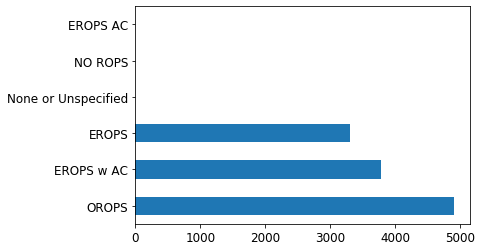

In [37]:
# we are just going to make a copy of the validation set and see the frequency of values in a particular column(enclosure)
x = raw_valid.copy()
x['pred_std'] = np.std(preds, axis=0)
x['pred'] = np.mean(preds, axis=0)
x.Enclosure.value_counts().plot.barh();

In [38]:
# returning the mean of saleprice, pred, and pred_std of particular values in a column(enclosure)
flds = ['Enclosure', 'SalePrice', 'pred', 'pred_std']
enc_summ = x[flds].groupby('Enclosure', as_index=False).mean()
enc_summ

,Enclosure,SalePrice,pred,pred_std
0,EROPS,9.849178,9.838176,0.273147
1,EROPS AC,NaN,NaN,NaN
2,EROPS w AC,10.623971,10.578398,0.265094
3,NO ROPS,NaN,NaN,NaN
4,None or Unspecified,NaN,NaN,NaN
5,OROPS,9.682064,9.681785,0.219408


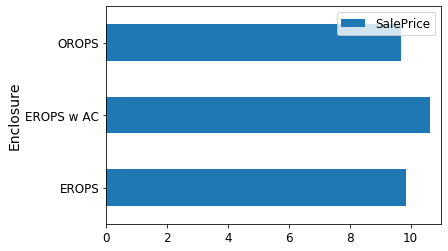

In [39]:
enc_summ = enc_summ[~pd.isnull(enc_summ.SalePrice)]
enc_summ.plot('Enclosure', 'SalePrice', 'barh', xlim=(0,11));

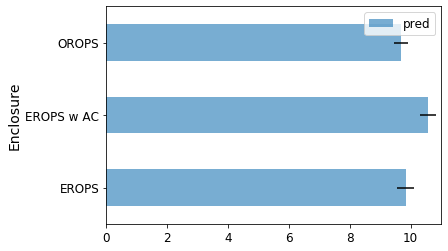

In [40]:
enc_summ.plot('Enclosure', 'pred', 'barh', xerr='pred_std', alpha=0.6, xlim=(0,11));

*Question*: Why are the predictions nearly exactly right, but the error bars are quite wide?

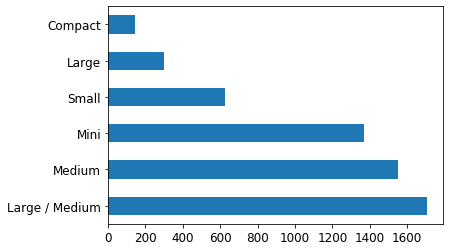

In [41]:
raw_valid.ProductSize.value_counts().plot.barh();

In [42]:
flds = ['ProductSize', 'SalePrice', 'pred', 'pred_std']
summ = x[flds].groupby(flds[0]).mean()
summ

,SalePrice,pred,pred_std
ProductSize,,,
Compact,9.735093,9.848137,0.353465
Large,10.470589,10.373615,0.353494
Large / Medium,10.691871,10.645697,0.299956
Medium,10.681511,10.622095,0.283964
Mini,9.535147,9.563557,0.248323
Small,10.324448,10.328558,0.304780


In [43]:
(summ.pred_std/summ.pred).sort_values(ascending=False)

ProductSize
Compact           0.035892
Large             0.034076
Small             0.029508
Large / Medium    0.028176
Medium            0.026733
Mini              0.025966
dtype: float64

# Feature importance

It's not normally enough to just to know that a model can make accurate predictions - we also want to know *how* it's making predictions. The most important way to see this is with *feature importance*.

In [44]:
pd.Series(data=m.feature_importances_,index=df_trn.columns).sort_values(ascending=False)[:10]

YearMade              0.174459
Coupler_System        0.102796
ProductSize           0.096709
fiProductClassDesc    0.093365
ModelID               0.057908
saleElapsed           0.049351
Grouser_Tracks        0.046639
Hydraulics_Flow       0.046445
fiSecondaryDesc       0.040821
Enclosure             0.038459
dtype: float64

In [45]:
fi = rf_feat_importance(m, df_trn); fi[:10]

,cols,imp
5,YearMade,0.174459
37,Coupler_System,0.102796
13,ProductSize,0.096709
14,fiProductClassDesc,0.093365
2,ModelID,0.057908
63,saleElapsed,0.049351
38,Grouser_Tracks,0.046639
39,Hydraulics_Flow,0.046445
10,fiSecondaryDesc,0.040821
19,Enclosure,0.038459


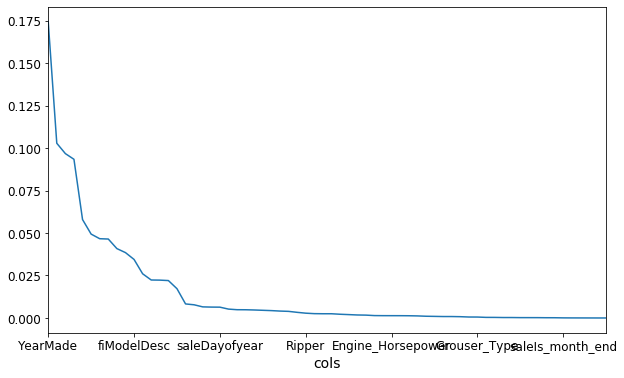

In [46]:
fi.plot('cols', 'imp', figsize=(10,6), legend=False);

In [47]:
def plot_fi(fi): return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

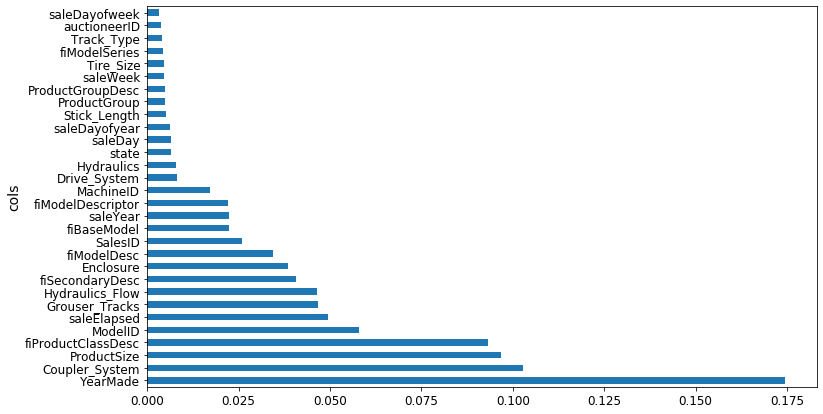

In [48]:
plot_fi(fi[:30]);

In [49]:
to_keep = fi[fi.imp>0.005].cols; len(to_keep)

22

In [50]:
df_keep = df_trn[to_keep].copy()
X_train, X_valid = split_vals(df_keep, n_trn)

In [51]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5,
                          n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.20720540382333355, 0.24594757655932503, 0.9102701419031398, 0.8919728125348704, 0.8938245270572668]


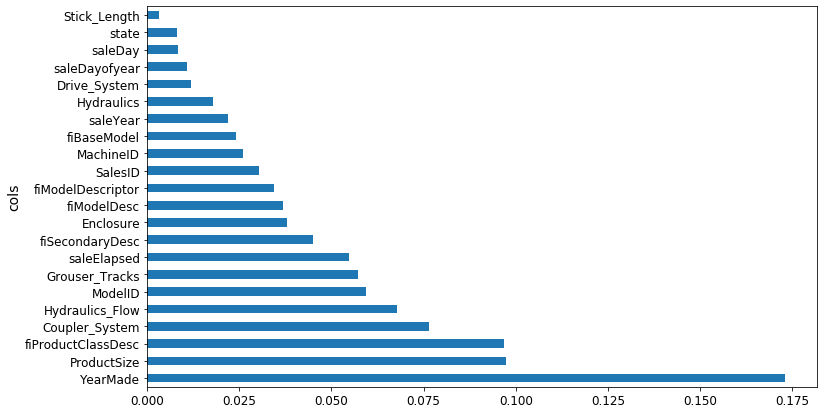

In [52]:
fi = rf_feat_importance(m, df_keep)
plot_fi(fi);

## One-hot encoding

proc_df's optional *max_n_cat* argument will turn some categorical variables into new columns.

For example, the column **ProductSize** which has 6 categories:

* Large
* Large / Medium
* Medium
* Compact
* Small
* Mini

gets turned into 6 new columns:

* ProductSize_Large
* ProductSize_Large / Medium
* ProductSize_Medium
* ProductSize_Compact
* ProductSize_Small
* ProductSize_Mini

and the column **ProductSize** gets removed.<br> <br>
The reason why we are selecting all 6 categories as new columns is that, if we had only 5 columns then the way RF would need to make a decision based on the 6th category is through going through all the five other categories as the only way to infer about the 6th category is by going through all the 5 others. In case of a linear model we do always create n-1 columns to escape multicollinearity, which isn't a problem in RF and therefore n columns can be made for *one hot encoding*.

It will only happen to columns whose number of categories is no bigger than the value of the *max_n_cat* argument.

Now some of these new columns may prove to have more important features than in the earlier situation, where all categories were in one column. <br><br>

**Note:** If you have some ordered category from before hand such as Usage band then before passing the df into proc_df just convert the variable into numeric data to preserve the ordered category by assigning it as: **df_raw.UsageBand = df_raw.UsageBand.cat.codes**

In [53]:
df_trn2, y_trn, nas = proc_df(df_raw, 'SalePrice', max_n_cat=7) # max_n_cat=7 tells us that any variables with < 7 
# categories will be one hot encoded
X_train, X_valid = split_vals(df_trn2, n_trn)

m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.6, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.20732178394531064, 0.2533685329018434, 0.9101693172691316, 0.8853554728512176, 0.8924709109966917]


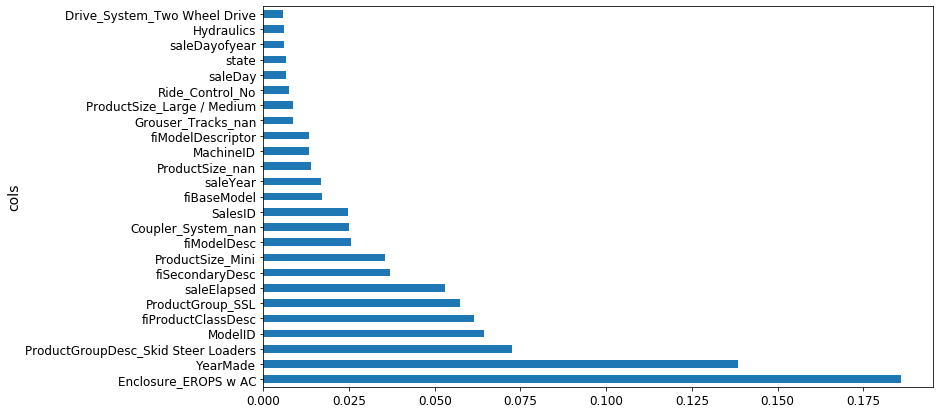

In [54]:
fi = rf_feat_importance(m, df_trn2)
plot_fi(fi[:25]);

# Removing redundant features

One thing that makes this harder to interpret is that there seem to be some variables with very similar meanings. Let's try to remove redundent features. <br><br>

In **agglomerative/hierarchical** clustering we always look at a pair of objects, take the midpoint of the two to make it into a single point and delete the two objects. As we keep removing the points and replacing it with their averages, we gradually reduce points. <br><br>

**Spearman's rank correlation** if the data has a linear relationship then **pearson's** correlation works. However, for *non-linear* data we need to use **spearman's correlation**. The idea is that we *rank* the data by x&y axis so that instead of plotting the data like in **pearson's** we plot the *rank*, which will result in a linear line. refer to the images below 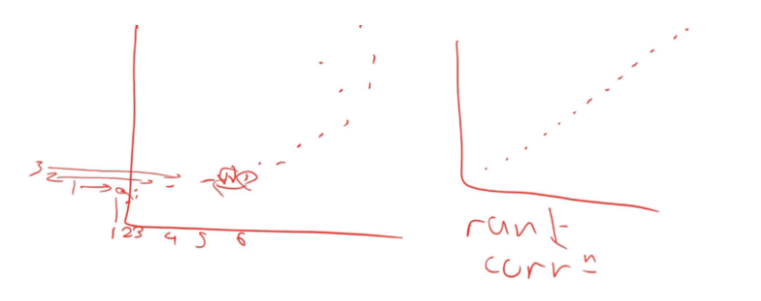 If you think about it, the rank of this dataset is going to look like an exact line because every time something was greater on the x-axis, it was also greater on the y-axis. So if we do a correlation on the rank, that’s called a rank correlation.
**Note** the data has to be *monotone*. 

In [55]:
from scipy.cluster import hierarchy as hc

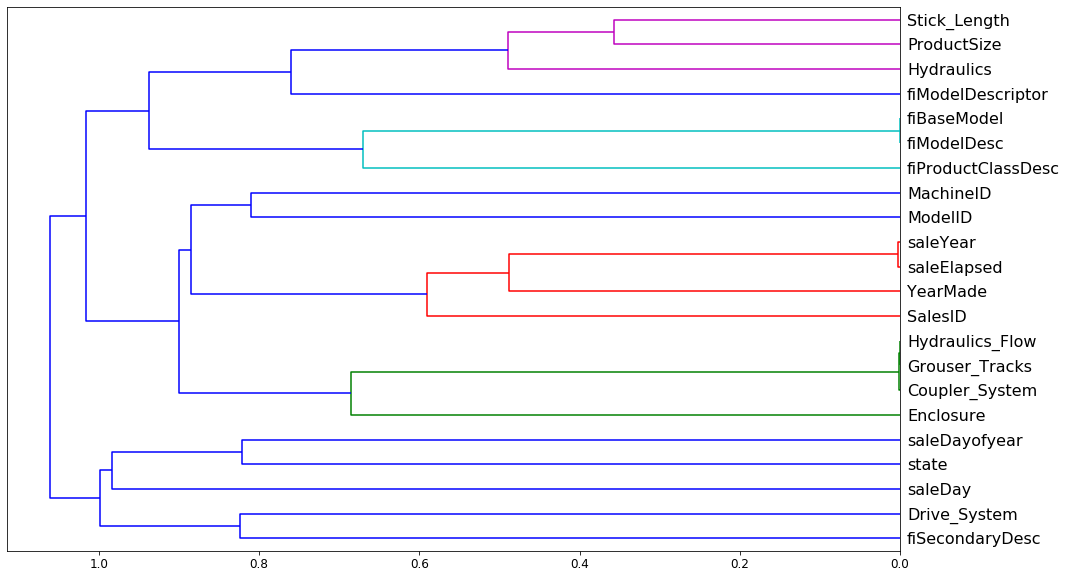

In [56]:
corr = np.round(scipy.stats.spearmanr(df_keep).correlation, 4) # returns the ranked correlation for all the columns
corr_condensed = hc.distance.squareform(1-corr) # creates a correlation matrix
z = hc.linkage(corr_condensed, method='average') # creates a hierarchical cluster (hc)
fig = plt.figure(figsize=(16,10))
dendrogram = hc.dendrogram(z, labels=df_keep.columns, orientation='left', leaf_font_size=16) # creates a dendrogram of hc
plt.show()

Let's try removing some of these related features to see if the model can be simplified without impacting the accuracy.

In [57]:
def get_oob(df):
    m = RandomForestRegressor(n_estimators=30, min_samples_leaf=5, max_features=0.6, n_jobs=-1, oob_score=True)
    x, _ = split_vals(df, n_trn)
    m.fit(x, y_train)
    return m.oob_score_

Here's our baseline.

In [58]:
get_oob(df_keep)

0.8899115171119829

Now we try removing each variable one at a time.<br><br><br> **Another approach**<br> We could however keep the columns but shuffle the data of each of the column and check the `oob_score`. This would yield the same result as well. 

In [59]:
for c in ('saleYear', 'saleElapsed', 'fiModelDesc', 'fiBaseModel', 'Grouser_Tracks', 'Coupler_System'):
    print(c, get_oob(df_keep.drop(c, axis=1)))

saleYear 0.8890158038875661
saleElapsed 0.8873119315802821
fiModelDesc 0.8879540484716949
fiBaseModel 0.888375240113354
Grouser_Tracks 0.8897432120503782
Coupler_System 0.8891864922216679


It looks like we can try one from each group for removal. Let's see what that does.

In [60]:
to_drop = ['saleYear', 'fiBaseModel', 'Grouser_Tracks']
get_oob(df_keep.drop(to_drop, axis=1))

0.8881210066292003

Looking good! Let's use this dataframe from here. We'll save the list of columns so we can reuse it later.

In [61]:
df_keep.drop(to_drop, axis=1, inplace=True)
X_train, X_valid = split_vals(df_keep, n_trn)

In [63]:
np.save(f'{PATH}/Converted Data/keep_cols.npy', np.array(df_keep.columns)) # saving the list of columns to keep 
# in np format

In [65]:
keep_cols = np.load(f'{PATH}/Converted Data/keep_cols.npy',allow_pickle=True)
df_keep = df_trn[keep_cols]

And let's see how this model looks on the full dataset.

In [ ]:
reset_rf_samples()

In [ ]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

# Partial dependence

The idea of **partial dependence plots** is to understand the impact of one independent variable(YearMade) on the dependent variable (Saleprice) given all else is equal, which means that what's the relationship between YearMade and Saleprice keeping all other independent variables equal (isolation of the impact of YearMade). Intuitively we would like to see an increase in price(Saleprice) for the most recent bulldozers. Another analogy is “All other things being equal” basically means if we sold something in 1990 vs. 1980 and it was exactly the same thing to exactly the same person in exactly the same auction so on and so forth, what would have been the difference in price?<br><br>
**Methodology**<br>
Here is our dataset of 500 auctions and here is our columns, one of which is the thing that we are interested in which is `YearMade`. We are now going to try and create a chart where we say all other things being equal in 1960, how much did things cost in auctions? The way we are going to do that is we are going to replace the `YearMade` column with 1960. We are going to copy in the value 1960 again and again all the way down. Now every row, the year made is 1960 and all of the other data is going to be exactly the same. We are going to take our random forest, we are going to pass all this through our random forest to predict the sale price. That will tell us for everything that was auctioned, how much do we think it would have been sold for if that thing was made in 1960. And that’s what we are going to plot on the right.
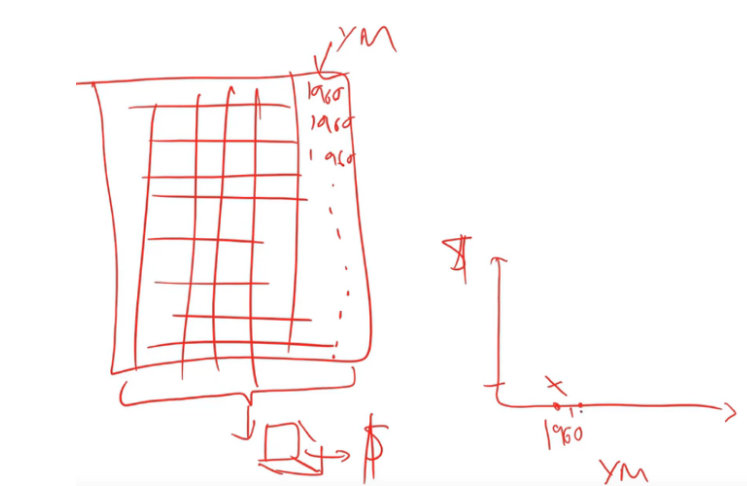

In [112]:
from pdpbox import pdp
from plotnine import * # this library is for enabling ggplot in python

In [113]:
set_rf_samples(50000)

This next analysis will be a little easier if we use the 1-hot encoded categorical variables, so let's load them up again.

In [114]:
df_trn2, y_trn, nas = proc_df(df_raw, 'SalePrice', max_n_cat=7)
X_train, X_valid = split_vals(df_trn2, n_trn)
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.6, n_jobs=-1)
m.fit(X_train, y_train);

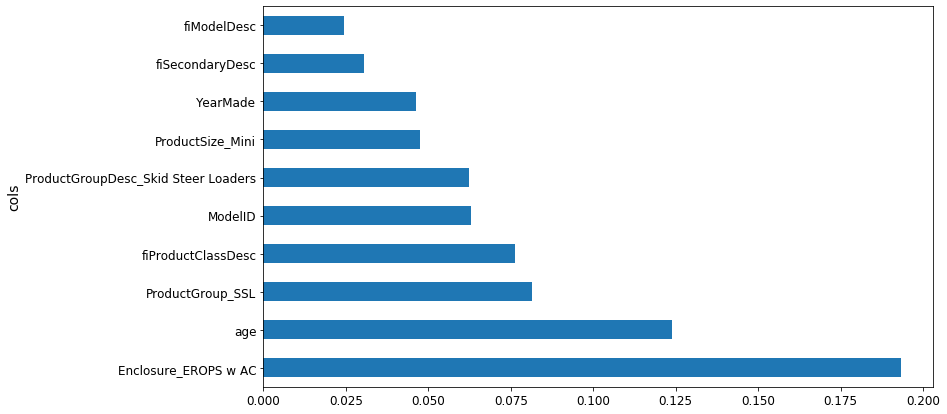

In [115]:
plot_fi(rf_feat_importance(m, df_trn2)[:10]);

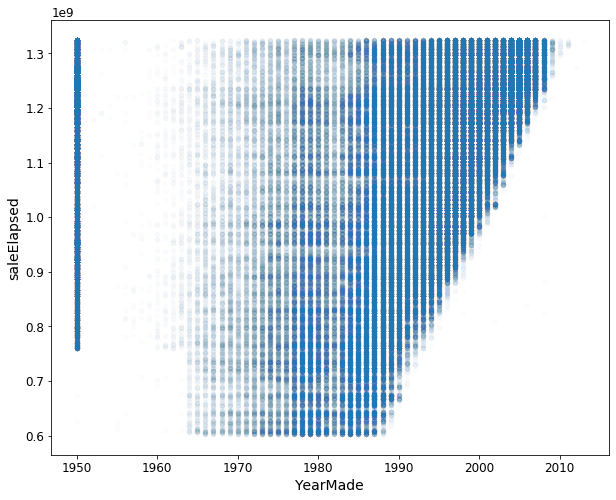

In [116]:
df_raw.plot('YearMade', 'saleElapsed', 'scatter', alpha=0.01, figsize=(10,8)); # saleElapsed vs YearMade and noticing 
# that there are certain bulldozers which are made in 1000, which doesn't make sense

In [117]:
x_all = get_sample(df_raw[df_raw.YearMade>1930], 500) #getting a sample  of the data > 1930 to be able to better understand
# the impact of YearMade of SalePrice

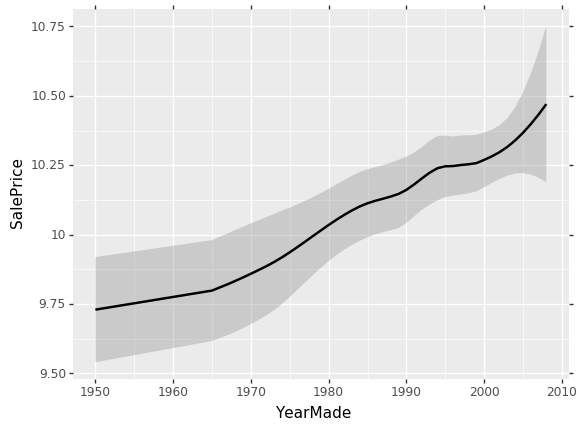

<ggplot: (158244483760)>

In [118]:
ggplot(x_all, aes('YearMade', 'SalePrice'))+stat_smooth(se=True, method='loess') 
# making a ggplot of SalePrice vs YearMade for all the subset of points and adding a smoothing factor to it so that we can
# have a line instead of multiple points scattered all over the place; here se = True, which returns the confidence error 
# and the method of creating a smoothing line is by locally weighted regression (loess)

In [119]:
x = get_sample(X_train[X_train.YearMade>1930], 500)

In [120]:
def plot_pdp(feat, clusters=None, feat_name=None):
    feat_name = feat_name or feat # taking either feat_name or feat
    p = pdp.pdp_isolate(m, x, feat) # isolating the feature that we want by taking the RF model, subsetted data and feat
    return pdp.pdp_plot(p, feat_name, plot_lines=True,
                        cluster=clusters is not None,
                        n_cluster_centers=clusters) # plotting the pdp plot or cluster

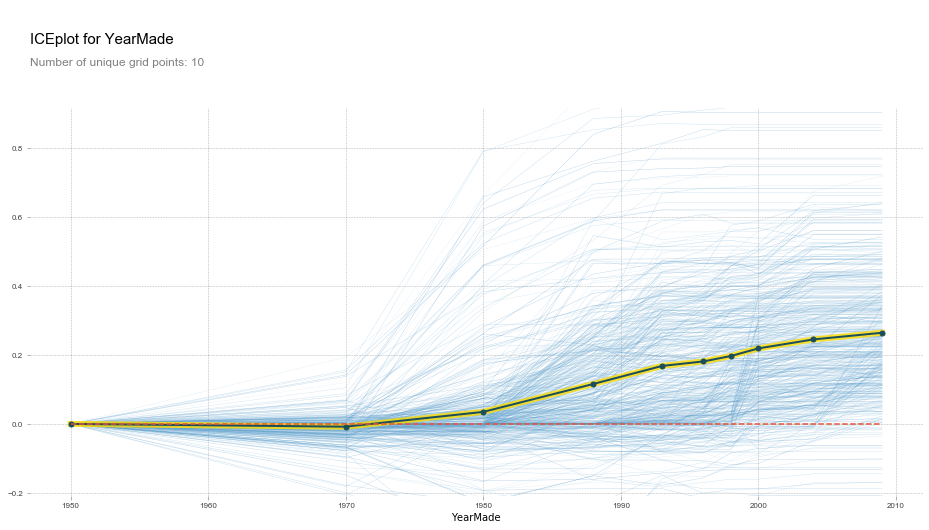

In [121]:
plot_pdp('YearMade') # we clearly see that the recent bulldozers are costlier than the older ones, the dip in price point
# shown in the smoothing curve doesn't appear here as there is almost a line indicating the increase in price after 
# 1990; all the lines are actually for 500 data points and the darkest line is the average of all the 500 points. 

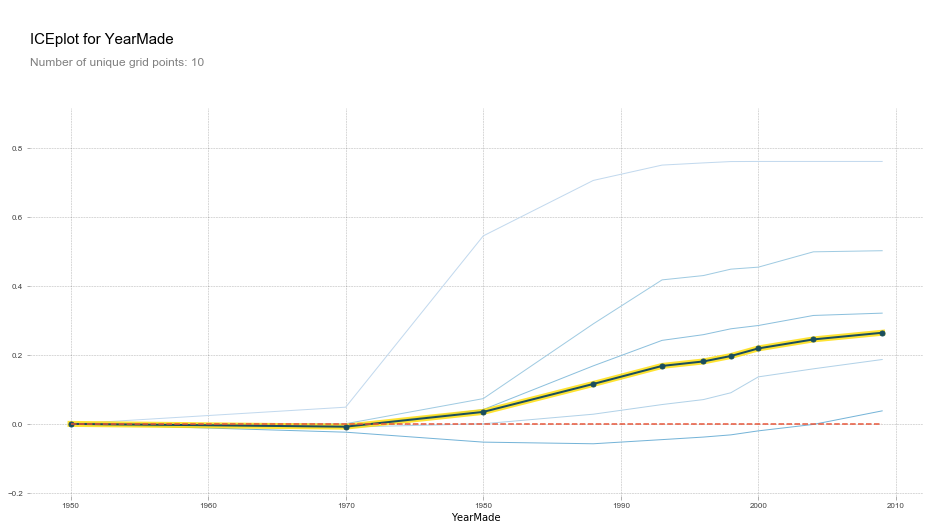

In [122]:
plot_pdp('YearMade', clusters=5) # we can also apply the cluster method to pdp to find out the most common shapes that 
# we see, it looks like some kinds of vehicle, after 1990, their prices are pretty flat. 
# Before that, they were pretty linear. Some other kinds of vehicle were exactly the opposite, 
# so different kinds of vehicle have these different shapes.

### PDP Plot Error

If you encounter the error below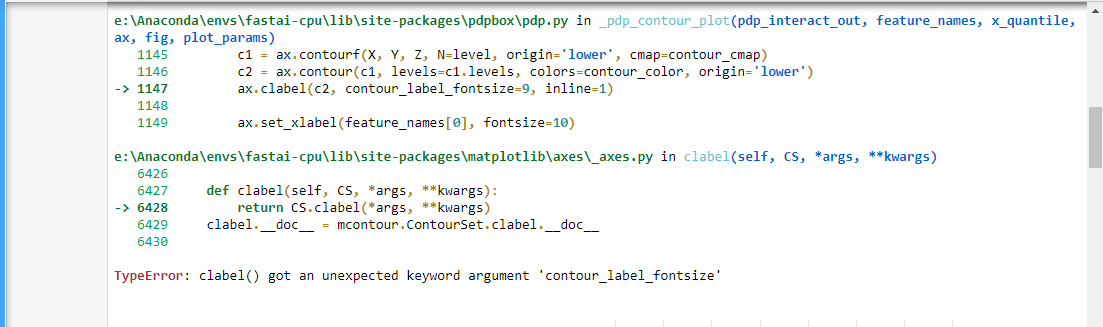 for the latest version of matplotlib a& pdp package then go into the path = env\Lib\site-packages\pdpbox and open pdp.py in an editor. Edit the line #1147 from ax.clabel(c2, contour_label_fontsize=9,inline=1) to **ax.clabel(c2, fontsize=9,inline=1)**

### PDP Interact plot

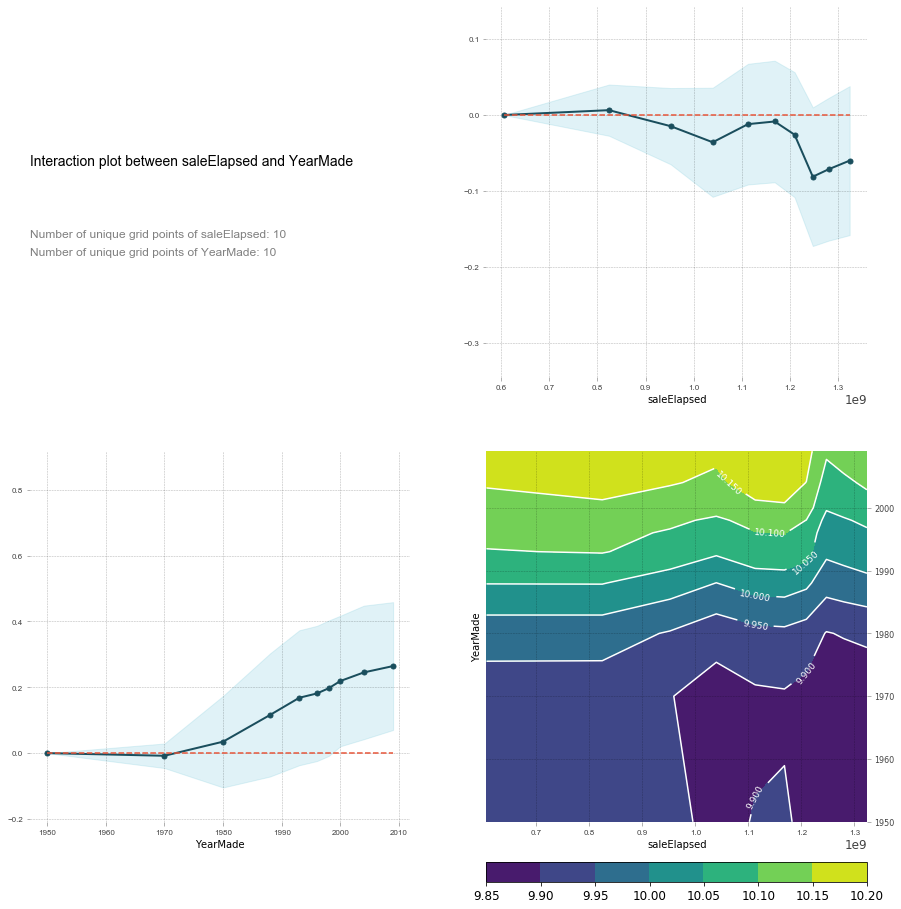

In [124]:
feats = ['saleElapsed', 'YearMade'] #interaction plots for saleElapsed vs price and YearMade vs price and the combination
# of both of them vs price. we can still confirm the same intuition through these plots as it depicts that the most recent 
# bulldozers are costlier than older ones
p = pdp.pdp_interact(m, x, feats)
pdp.pdp_interact_plot(p, feats)

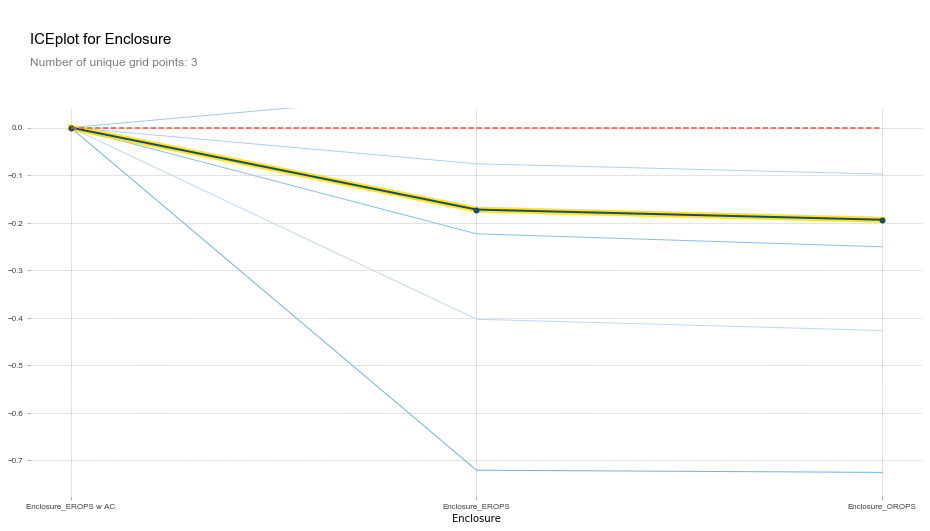

In [85]:
plot_pdp(['Enclosure_EROPS w AC', 'Enclosure_EROPS', 'Enclosure_OROPS'], 5, 'Enclosure')# looking at the different 
# enclosures and it's impact on price. here enclosed w ac is costlier as per the intuition

In [86]:
df_raw.YearMade[df_raw.YearMade<1950] = 1950
df_keep['age'] = df_raw['age'] = df_raw.saleYear-df_raw.YearMade # making an age column in df_raw and then adding to df_keep

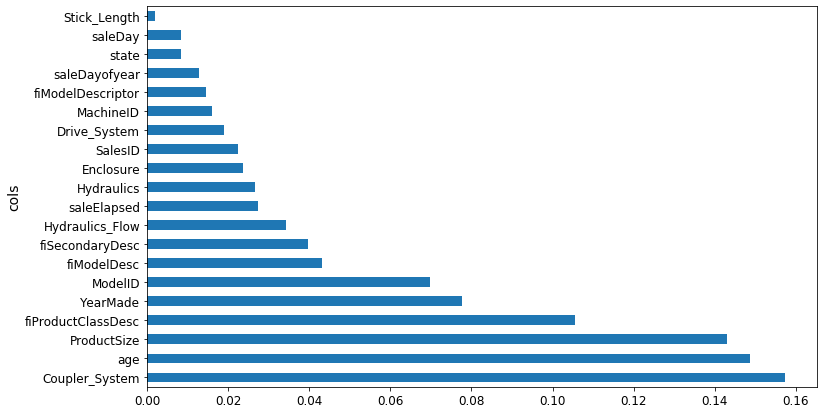

In [87]:
X_train, X_valid = split_vals(df_keep, n_trn)
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.6, n_jobs=-1)
m.fit(X_train, y_train)
plot_fi(rf_feat_importance(m, df_keep));

# Tree interpreter

This is **super important** for interpretation of  *RF*. <br><br>Supposing we were asked, "Why is the premium of my insurance higher by \$500 this year". To answer this question we would need to use the **tree interpreter**. Each *row* corresponds to a different customer. Here, we are going to pick column #0, as all the rows are columns here,and pass in my *RF model* and the *row* and it will return three things i.e. prediction, bias and contributions. 
- Prediction: returns the predicition for the customer
- Bias: returns the average of the dependent across the whole dataset 
- Contribution: returns the value for each feature, which resulted in the value of the prediction from the bias i.e. bias-contributions = predicition; it also quantifies on an average each feature needed to build the tree



In [88]:
from treeinterpreter import treeinterpreter as ti

In [89]:
df_train, df_valid = split_vals(df_raw[df_keep.columns], n_trn)

In [90]:
row = X_valid.values[None,0]; row # taking one single row i.e. one customer. as the rows are columns we are choosing a col

array([[      1999,          0,          5,         17,        665, 1284595200,          0,          0,
                 1,       3232,    4364751,          0,    2300944,          0,         12,         35,
                16,        259,         29,         11]], dtype=int64)

In [91]:
prediction, bias, contributions = ti.predict(m, row) # ti takes in the random forest model and the concerned row and 
# returns predicition, bias and contributions

In [92]:
prediction[0], bias[0]

(array([9.25295]), 10.105954733078464)

In [94]:
[o for o in zip(df_keep.columns[idxs], df_valid.iloc[0][idxs], contributions[0][idxs])] # sorting the columns of df_keep
# the values of df_valid according to the contributions; this will give us the original values along with feature names
# and their respective values

[('ProductSize', 'Mini', -0.620865907334428),
 ('age', 11, -0.14468729819031984),
 ('fiProductClassDesc',
  'Hydraulic Excavator, Track - 3.0 to 4.0 Metric Tons',
  -0.10539695469198214),
 ('fiModelDesc', 'KX1212', -0.0759226885611782),
 ('fiSecondaryDesc', nan, -0.06270069978601663),
 ('Enclosure', 'EROPS', -0.027400867360499827),
 ('saleElapsed', 1284595200, -0.019116514082700542),
 ('fiModelDescriptor', nan, -0.016992085816884252),
 ('state', 'Ohio', -0.005529066644180425),
 ('Stick_Length', 'None or Unspecified', -0.004480646005284727),
 ('saleDay', 16, -0.001617254475847396),
 ('MachineID', 2300944, -0.0004413620500014481),
 ('saleDayofyear', 259, 0.0026789375796326454),
 ('Drive_System', nan, 0.005553618739070299),
 ('SalesID', 4364751, 0.009652685635744573),
 ('ModelID', 665, 0.012646440375060398),
 ('Hydraulics_Flow', nan, 0.015873826714032237),
 ('Hydraulics', 'Standard', 0.021426108087192162),
 ('Coupler_System', nan, 0.0735702004705077),
 ('YearMade', 1999, 0.090748173271056

In [105]:
contributions[0].sum() # total of all the features 

-0.8530013541270269

# Extrapolation

In [ ]:
df_ext = df_keep.copy()
df_ext['is_valid'] = 1
df_ext.is_valid[:n_trn] = 0
x, y, nas = proc_df(df_ext, 'is_valid')

In [ ]:
m = RandomForestClassifier(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(x, y);
m.oob_score_

0.99998753505765037

In [ ]:
fi = rf_feat_importance(m, x); fi[:10]

,cols,imp
9,SalesID,0.764744
5,saleElapsed,0.146162
11,MachineID,0.077919
8,fiModelDesc,0.002931
20,saleDayofyear,0.002569
0,YearMade,0.002358
22,age,0.001202
4,ModelID,0.000664
6,fiSecondaryDesc,0.000361
1,Coupler_System,0.000208


In [ ]:
feats=['SalesID', 'saleElapsed', 'MachineID']

In [ ]:
(X_train[feats]/1000).describe()

,SalesID,saleElapsed,MachineID
count,389125.000000,389125.000000,389125.000000
mean,1800.452485,5.599522,1206.796148
std,595.627288,2.087862,430.850552
min,1139.246000,0.000000,0.000000
25%,1413.348000,4.232000,1087.016000
50%,1632.093000,6.176000,1273.859000
75%,2210.453000,7.328000,1458.661000
max,4364.741000,8.381000,2313.821000


In [ ]:
(X_valid[feats]/1000).describe()

,SalesID,saleElapsed,MachineID
count,12000.000000,12000.000000,12000.000000
mean,5786.967651,8.166793,1578.049709
std,836.899608,0.289098,589.497173
min,4364.751000,6.638000,0.830000
25%,4408.580750,8.197000,1271.225250
50%,6272.538500,8.276000,1825.317000
75%,6291.792250,8.338000,1907.858000
max,6333.342000,8.382000,2486.330000


In [ ]:
x.drop(feats, axis=1, inplace=True)

In [ ]:
m = RandomForestClassifier(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(x, y);
m.oob_score_

0.9789018385789966

In [ ]:
fi = rf_feat_importance(m, x); fi[:10]

,cols,imp
19,age,0.233626
0,YearMade,0.188127
17,saleDayofyear,0.157429
4,ModelID,0.077623
7,fiModelDesc,0.061301
15,saleDay,0.056252
14,state,0.055201
3,fiProductClassDesc,0.035131
5,fiSecondaryDesc,0.023661
6,Enclosure,0.022409


In [ ]:
set_rf_samples(50000)

In [ ]:
feats=['SalesID', 'saleElapsed', 'MachineID', 'age', 'YearMade', 'saleDayofyear']

In [ ]:
X_train, X_valid = split_vals(df_keep, n_trn)
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.21136509778791376, 0.2493668921196425, 0.90909393040946562, 0.88894821098056087, 0.89255408392415925]


In [ ]:
for f in feats:
    df_subs = df_keep.drop(f, axis=1)
    X_train, X_valid = split_vals(df_subs, n_trn)
    m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
    m.fit(X_train, y_train)
    print(f)
    print_score(m)

SalesID
[0.20918653475938534, 0.2459966629213187, 0.9053273181678706, 0.89192968797265737, 0.89245205174299469]
saleElapsed
[0.2194124612957369, 0.2546442621643524, 0.90358104739129086, 0.8841980790762114, 0.88681881032219145]
MachineID
[0.206612984511148, 0.24446409479358033, 0.90312476862123559, 0.89327205732490311, 0.89501553584754967]
age
[0.21317740718919814, 0.2471719147150774, 0.90260198977488226, 0.89089460707372525, 0.89185129799503315]
YearMade
[0.21305398932040326, 0.2534570148977216, 0.90555219348567462, 0.88527538596974953, 0.89158854973045432]
saleDayofyear
[0.21320711524847227, 0.24629839782893828, 0.90881970943169987, 0.89166441133215968, 0.89272793857941679]


In [ ]:
reset_rf_samples()

In [ ]:
df_subs = df_keep.drop(['SalesID', 'MachineID', 'saleDayofyear'], axis=1)
X_train, X_valid = split_vals(df_subs, n_trn)
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.1418970082803121, 0.21779153679471935, 0.96040441863389681, 0.91529091848161925, 0.90918594039522138]


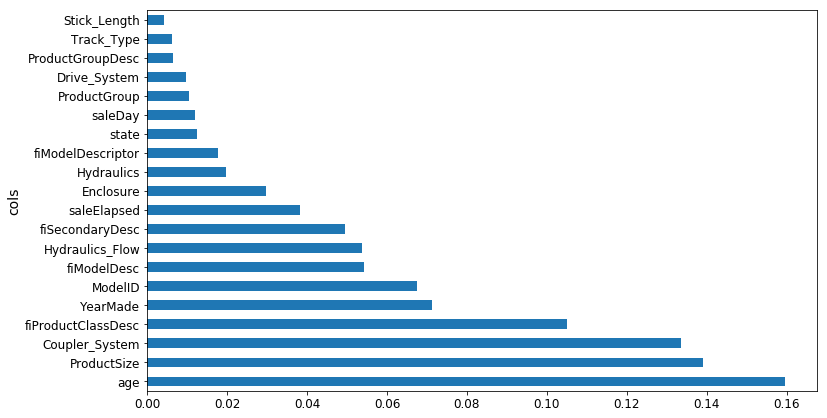

In [ ]:
plot_fi(rf_feat_importance(m, X_train));

In [ ]:
np.save(f'{PATH}/Converted Data/subs_cols.npy', np.array(df_subs.columns))

# Our final model!

In [ ]:
m = RandomForestRegressor(n_estimators=160, max_features=0.5, n_jobs=-1, oob_score=True)
%time m.fit(X_train, y_train)
print_score(m)

CPU times: user 6min 3s, sys: 2.75 s, total: 6min 6s
Wall time: 16.7 s
[0.08104912951128229, 0.2109679613161783, 0.9865755186304942, 0.92051576728916762, 0.9143700001430598]
